#**Estudo de Caso 1 "QM9 Dataset" do artigo PiNN: A Python Library for Building Atomic Neural Networks of Molecules and Materials**

Etapa 1: Instalar dependências

In [ ]:
# Instala PyTorch versão compatível com CPU
!pip install torch==2.1.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

# Instala torch-scatter e torch-geometric para CPU
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cpu.html
!pip install torch-geometric

Looking in indexes: https://download.pytorch.org/whl/cpu
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cpu.html


In [ ]:
!pip install "numpy<2"

In [ ]:
import torch
from torch_geometric.nn import GCNConv, global_mean_pool

print("PyTorch:", torch.__version__)
print("CUDA disponível:", torch.cuda.is_available())

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


PyTorch: 2.1.0+cpu
CUDA disponível: False


Etapa 2: Carregar e preparar o dataset

In [ ]:
import torch
from torch_geometric.datasets import QM9
from torch_geometric.transforms import AddSelfLoops
from torch_geometric.loader import DataLoader

# Carrega o dataset com transformação de auto-laços
transform = AddSelfLoops()
dataset = QM9(root='data/QM9', transform=transform)

# Índice da propriedade alvo: U₀ (energia interna)
target_idx = 2

# Normaliza o alvo
targets = dataset.data.y[:, target_idx]
mean = targets.mean()
std = targets.std()
dataset.data.y[:, target_idx] = (targets - mean) / std

# Divide o dataset
train_dataset = dataset[:100000]
val_dataset = dataset[100000:]

# Cria os DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

/usr/local/lib/python3.11/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Etapa 3: Definir o modelo GCN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class EnergyPredictor(nn.Module):
    def __init__(self, in_channels=dataset.num_node_features, hidden=64):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.fc = nn.Linear(hidden, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.fc(x).squeeze(-1)

Etapa 4: Treinamento e avaliação

In [ ]:
from torch.optim import Adam

device = torch.device('cpu')

model = EnergyPredictor().to(device)
optimizer = Adam(model.parameters(), lr=3e-4)
loss_fn = nn.MSELoss()

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        pred = model(data)
        target = data.y[:, target_idx]
        loss = loss_fn(pred, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def evaluate(loader):
    model.eval()
    total_mae = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data)
            target = data.y[:, target_idx]
            total_mae += (pred - target).abs().sum().item()
    return total_mae / len(loader.dataset)

Etapa 5: Loop de treinamento

In [ ]:
torch.device('cuda')

for epoch in range(1, 21):
    train_loss = train()
    val_mae = evaluate(val_loader)
    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Validation MAE: {val_mae * std:.4f} eV")

Epoch 01 | Train Loss: 0.8915 | Validation MAE: 0.3691 eV
Epoch 02 | Train Loss: 0.7536 | Validation MAE: 0.3704 eV
Epoch 03 | Train Loss: 0.7001 | Validation MAE: 0.3668 eV
Epoch 04 | Train Loss: 0.6738 | Validation MAE: 0.3648 eV
Epoch 05 | Train Loss: 0.6564 | Validation MAE: 0.3792 eV
Epoch 06 | Train Loss: 0.6391 | Validation MAE: 0.3580 eV
Epoch 07 | Train Loss: 0.6256 | Validation MAE: 0.3578 eV
Epoch 08 | Train Loss: 0.6157 | Validation MAE: 0.3672 eV
Epoch 09 | Train Loss: 0.6088 | Validation MAE: 0.3523 eV
Epoch 10 | Train Loss: 0.6027 | Validation MAE: 0.3537 eV
Epoch 11 | Train Loss: 0.5966 | Validation MAE: 0.3526 eV
Epoch 12 | Train Loss: 0.5922 | Validation MAE: 0.3433 eV
Epoch 13 | Train Loss: 0.5875 | Validation MAE: 0.3511 eV
Epoch 14 | Train Loss: 0.5818 | Validation MAE: 0.3520 eV
Epoch 15 | Train Loss: 0.5766 | Validation MAE: 0.3369 eV
Epoch 16 | Train Loss: 0.5719 | Validation MAE: 0.3451 eV
Epoch 17 | Train Loss: 0.5668 | Validation MAE: 0.3483 eV
Epoch 18 | Tra

Gerar gráfico

Aqui uma pequena diferença entre os resultados que fiz com os do artigo, o eixo X está rotulado como se fossem cargas CM5, quando na verdade os dados representam valores de energia interna U₀, normalizados e depois desnormalizados

In [ ]:
!pip install seaborn scipy matplotlib

In [ ]:
import numpy as np

model.eval()
cm5_charges = []
predicted_charges = []

with torch.no_grad():
    for data in val_loader:
        data = data.to(device)
        pred = model(data).squeeze().cpu().numpy()
        target = data.y[:, target_idx].cpu().numpy()
        predicted_charges.extend(pred)
        cm5_charges.extend(target)

cm5_charges = np.array(cm5_charges)
predicted_charges = np.array(predicted_charges)

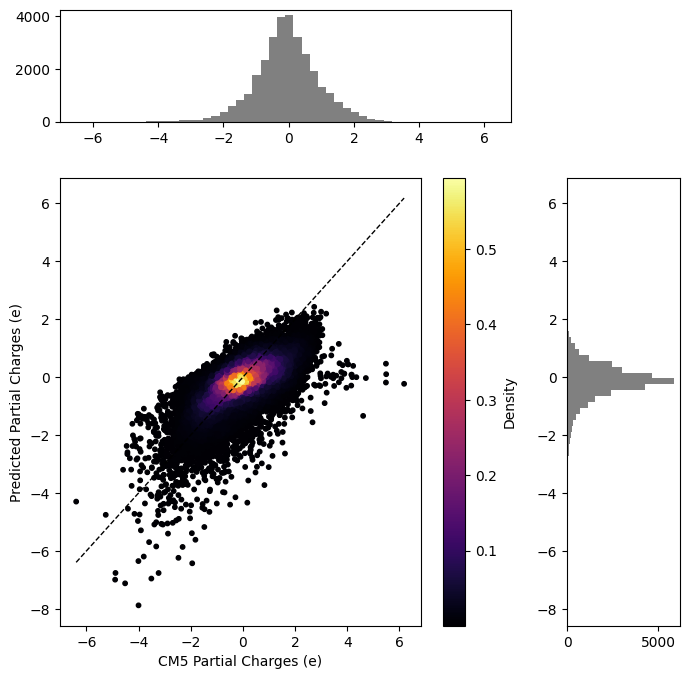

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# Calcula densidade
xy = np.vstack([cm5_charges, predicted_charges])
z = gaussian_kde(xy)(xy)

# Cria figura com marginais
fig = plt.figure(figsize=(8, 8))
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.5)
main_ax = fig.add_subplot(grid[1:, :-1])
x_hist = fig.add_subplot(grid[0, :-1], sharex=main_ax)
y_hist = fig.add_subplot(grid[1:, -1], sharey=main_ax)

# Scatter plot com densidade
sc = main_ax.scatter(cm5_charges, predicted_charges, c=z, cmap='inferno', s=10)
main_ax.plot([cm5_charges.min(), cm5_charges.max()],
             [cm5_charges.min(), cm5_charges.max()], 'k--', lw=1)
main_ax.set_xlabel('CM5 Partial Charges (e)')
main_ax.set_ylabel('Predicted Partial Charges (e)')

# Histogramas marginais
x_hist.hist(cm5_charges, bins=50, color='gray')
y_hist.hist(predicted_charges, bins=50, orientation='horizontal', color='gray')

# Barra de cor
cbar = fig.colorbar(sc, ax=main_ax, orientation='vertical')
cbar.set_label('Density')

plt.show()